# VCF - Parametric low-pass filter

A low pass filter where the following parameters are independently controllable:

- Cutoff frequency
- Resonance

In [1]:
from numpy import *
from matplotlib.pyplot import *
from scipy import signal
import scipy.io.wavfile

In [2]:
class Simulator(object):
    def __init__(self, amplitude=2**15-1, yrange=[-50, 10]):
        self.amplitude = amplitude
        self.yrange = yrange
        
        self.fig, self.ax1 = subplots(1, 1, figsize=[8, 4])
        
        # Load/generate data files
        self.sample_rate_Hz = 44100
        fs, x = scipy.io.wavfile.read("../app/sound/prbs20.wav")
        assert(fs == self.sample_rate_Hz)
        self.x_prbs20 = self.amplitude * x/(2**15)
        
        t = arange(len(self.x_prbs20)) / self.sample_rate_Hz
        self.x_chirp = self.amplitude * signal.chirp(t, f0=20, f1=20e3, t1=max(t), method="linear")
    
    def vcf(self, x, cutoff, resonance):
        # Example filter
        b, a = signal.cheby1(2, 10, 1000 * 2/self.sample_rate_Hz, btype="low")
        return signal.lfilter(b, a, x)
    
    def simulate_chirp(self, cutoff, resonance):
        y = self.vcf(self.x_chirp, cutoff, resonance)
        
        f = linspace(20, 20e3, len(y))
        #H = 1/self.amplitude * y
        H = 1/self.amplitude * signal.hilbert(y)

        label = "cutoff={:.0f}, resonance={:.0f}".format(cutoff, resonance)
        self.plot_frequency_response(f, H, label=label)
        return 
    
    def simulate_prbs(self, cutoff, resonance, h_length=None):
        x = self.x_prbs20
        y = self.vcf(x, cutoff, resonance)
        
        if h_length is None:
            h_length = int(30/cutoff)

        t, h, f, H = self.analyze_prbs(x, y, h_length)
        label = "cutoff={:.0f}, resonance={:.0f}".format(cutoff, resonance)
        self.plot_frequency_response(f, H, label=label)
    
    def analyze_prbs(self, x, y, h_length):
        # Estimate impulse response using a pseudo-random bit sequence.
        h = signal.correlate(y, x, "full")
        h = h[len(h)//2:]

        # Limit the impulse response length to lower the noise
        h = h[0:h_length]
        t = arange(h_length)/self.sample_rate_Hz

        # Estimate frequency response
        H = fft.fft(h)
        H = H[0:len(H)//2] 
        H /= max(abs(H))
        f = linspace(0.01, self.sample_rate_Hz/2, len(H))

        return t, h, f, H

    def plot_frequency_response(self, f, H, label=None):
        self.ax1.semilogx(f, 20*ma.log10(abs(H)), label=label)

    def show(self):
        # Frequency response graph
        self.ax1.grid(True, "both", "both")
        self.ax1.legend()
        self.ax1.set_xlim(20, 20e3)
        self.ax1.set_ylim(*self.yrange)
        
        self.fig.tight_layout()
        #self.fig.show()


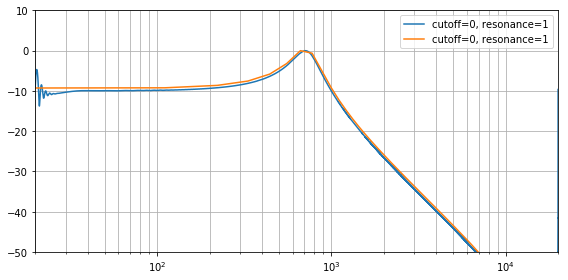

In [3]:
s = Simulator()
s.simulate_chirp(0.01, 1)
s.simulate_prbs(0.01, 1, h_length=400)
s.show()

## Zavalishin 2015 The Art of VA Filter Design

Due to the non-zero-feedback used here, the cutoff and resonance parameters are not decoupled and high cutoff's seem to increase resonance, possibly resulting in instability.

Ladder filter:
- Four single-pole filter, page 48.
- Feedback, page 63.

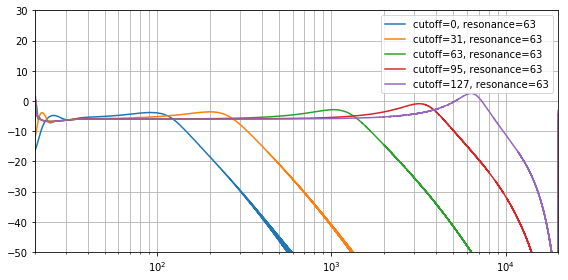

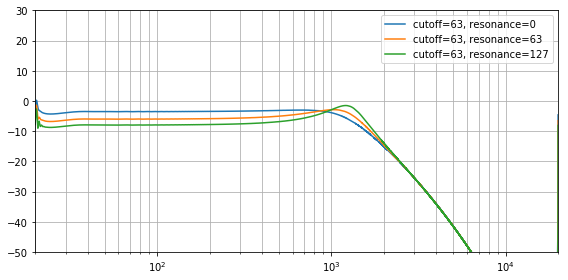

In [4]:
class Zavalishin(Simulator):
    def map_cutoff(self, value):
        assert(0 <= value <= 127)
        b = 0.01
        a = (0.9-b) / (127*127*127)
        return a*value*value*value + b

    def map_resonance(self, value):
        assert(0 <= value <= 127)
        b = 0.5
        a = (1.5-b) / 127
        return a*value + b
    
    def onepole(self, x, G, w1):
        v  = (x-w1) * G
        y = v + w1
        w1 = y + v
        return y, w1

    def vcf(self, x, cutoff, resonance):
        y = zeros(len(x))
        g = self.map_cutoff(cutoff)
        k = self.map_resonance(resonance)
        G = g/(1+g)

        w1 = [0, 0, 0, 0] # Delayed sum of y[n] and x[n]*G
        y1 = 0 # Delayed output
        for n in range(1, len(y)):
            x_ = x[n]
            y_ = x_ - y1*k
            
            y_, w1[0] = self.onepole(y_, G, w1[0])
            y_, w1[1] = self.onepole(y_, G, w1[1])
            y_, w1[2] = self.onepole(y_, G, w1[2])
            y_, w1[3] = self.onepole(y_, G, w1[3])
            
            y[n] = y_
            y1 = y_

        return y
    
# Sweep cutoff
s = Zavalishin(yrange=[-50, 30])
for cutoff in [0, 31, 63, 95, 127]:
    s.simulate_chirp(cutoff, 63)
s.show()

# Sweep resonance
s = Zavalishin(yrange=[-50, 30])
for res in [0, 63, 127]:
    s.simulate_chirp(63, res)
s.show()

In [ ]:
## Stilson and Smith 1996 Analyzing the Moog VCF with Considerations for Digital Implementation

Non-saturating filter with decoupled cutoff and resonance. Note that high resonances are not dampened and may cause overflow.

- Referred to in Valimaki 2006 Oscillator and Filter Algorithms for Virtual Analog Synthesis page 26.
- Here, a block diagram of the compromise onepole is shown.

In [5]:
class StilsonSmithCompromise(Simulator):
    def map_cutoff(self, value):
        assert(0 <= value <= 127)
        b = 0.02
        a = (0.8-b) / (127*127)
        return a*value*value + b

    def map_resonance(self, value):
        assert(0 <= value <= 127)
        b = 0.5
        a = (3.9-b) / 127
        return a*value + b
    
    def onepole(self, x, g, x1, y1):
        # Input -> summation point
        v = 1/1.3 * x + 0.3/1.3*x1
        
        # Summation point -> output
        y = (v-y1)*g + y1
        
        # Delay lines
        y1 = y
        x1 = x
        return y, x1, y1

    def vcf(self, x, cutoff, resonance):
        y = zeros(len(x))
        g = self.map_cutoff(cutoff)
        k = self.map_resonance(resonance)

        x1 = [0, 0, 0, 0] # Delayed onepole input
        y1 = [0, 0, 0, 0] # Delayed onepole output
        for n in range(1, len(y)):
            x_ = x[n]
            y_ = x_ - y1[3]*k
            
            y_, x1[0], y1[0] = self.onepole(y_, g, x1[0], y1[0])
            y_, x1[1], y1[1] = self.onepole(y_, g, x1[1], y1[1])
            y_, x1[2], y1[2] = self.onepole(y_, g, x1[2], y1[2])
            y_, x1[3], y1[3] = self.onepole(y_, g, x1[3], y1[3])
            y[n] = y_
            
        return y

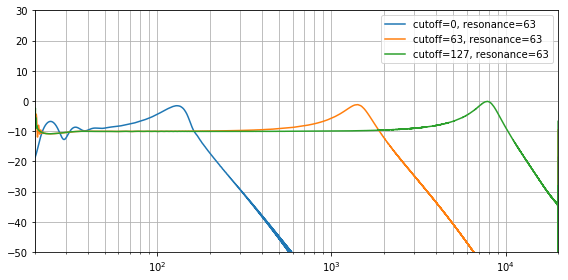

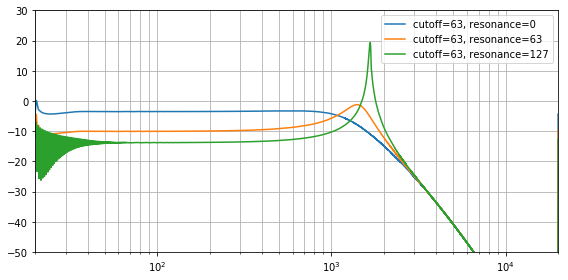

In [6]:
# Sweep cutoff
s = StilsonSmithCompromise(yrange=[-50, 30])
for cutoff in [0, 63, 127]:
    s.simulate_chirp(cutoff, 63)
s.show()

# Sweep resonance
s = StilsonSmithCompromise(yrange=[-50, 30])
for res in [0, 63, 127]:
    s.simulate_chirp(63, res)
s.show()

## Valimaki 2006 Oscillator and Filter Algorithms for Virtual Analog Synthesis

Single-saturating implementation.

Note, that this seems to generate aliasing!

- Page 27.
- Subfilters designed from Zavalishin 2015 The Art of VA Filter Design

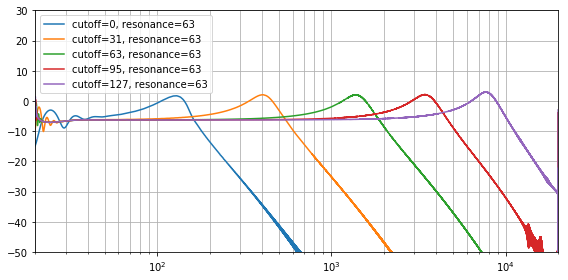

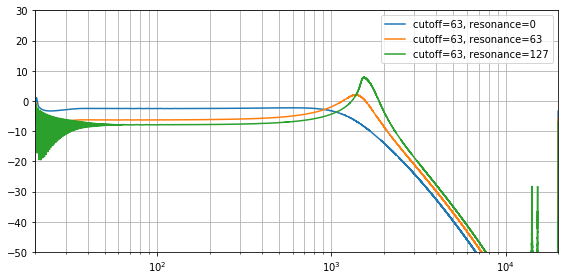

In [7]:
class ValimakiImprovedMoogFilter(StilsonSmithCompromise):
    def saturate(self, x):
        headroom = 10
        A = headroom * self.amplitude
        return A * tanh(x/(A))
    
    def vcf(self, x, cutoff, resonance):
        y = zeros(len(x))
        g = self.map_cutoff(cutoff)
        k = self.map_resonance(resonance)
        G_comp = 0.25

        x1 = [0, 0, 0, 0] # Delayed onepole input
        y1 = [0, 0, 0, 0] # Delayed onepole output
        for n in range(1, len(y)):
            y_ = x[n]
            y_ = y_ - k * (y1[3] - G_comp*y_)
            
            y_ = self.saturate(y_)
            
            y_, x1[0], y1[0] = self.onepole(y_, g, x1[0], y1[0])
            y_, x1[1], y1[1] = self.onepole(y_, g, x1[1], y1[1])
            y_, x1[2], y1[2] = self.onepole(y_, g, x1[2], y1[2])
            y_, x1[3], y1[3] = self.onepole(y_, g, x1[3], y1[3])
            y[n] = y_
            
        return y

# Sweep cutoff
s = ValimakiImprovedMoogFilter(yrange=[-50, 30])
for cutoff in [0, 31, 63, 95, 127]:
    s.simulate_chirp(cutoff, 63)
s.show()

# Sweep resonance
s = ValimakiImprovedMoogFilter(yrange=[-50, 30])
for res in [0, 63, 127]:
    s.simulate_chirp(63, res)
s.show()

## Pirkle 2019 Designing Audio Effects Plugins in C++

Non-saturating but with a hard limiter on the output.

Addendum A11.

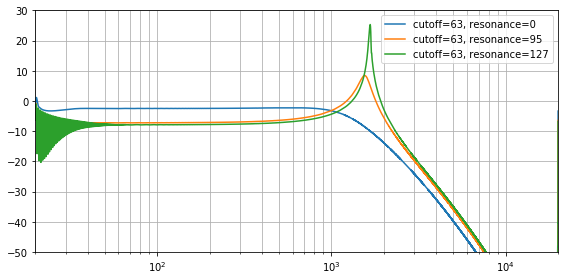

In [8]:
class Pirkle(StilsonSmithCompromise):
    def vcf(self, x, cutoff, resonance):
        y = zeros(len(x))
        g = self.map_cutoff(cutoff)
        k = self.map_resonance(resonance)
        G_comp = 0.25

        x1 = [0, 0, 0, 0] # Delayed onepole input
        y1 = [0, 0, 0, 0] # Delayed onepole output
        for n in range(1, len(y)):
            y_ = x[n]
            y_ = y_ - k * (y1[3] - G_comp*y_)
            
            y_, x1[0], y1[0] = self.onepole(y_, g, x1[0], y1[0])
            y_, x1[1], y1[1] = self.onepole(y_, g, x1[1], y1[1])
            y_, x1[2], y1[2] = self.onepole(y_, g, x1[2], y1[2])
            y_, x1[3], y1[3] = self.onepole(y_, g, x1[3], y1[3])
            y[n] = y_
            
        return y
    
# Sweep cutoff
#s = Pirkle(yrange=[-50, 30])
#for cutoff in [0, 63, 127]:
#    s.simulate_chirp(cutoff, 63)
#s.show()

# Sweep resonance
s = Pirkle(yrange=[-50, 30])
for resonance in [0, 95, 127]:
    s.simulate_chirp(63, resonance)
s.show()

## Peak limiter

Lyons 2011 Understanding digital signal processing Section 13.30.

/home/soren/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


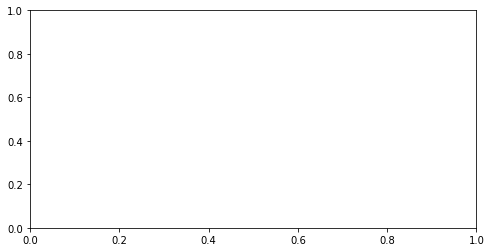

In [9]:
def limiter(x, R):
    a = 0.01
    y = zeros(len(x))
    
    w1 = 1 # Delayed feedback element
    
    for n in range(len(x)):  
        y[n] = x[n] * w1
        
        w = y[n]*y[n]
        w = R - w
        w = w + w1
        w1 = w
        
    return y
        
        
s = Pirkle(yrange=[-50, 30])
y = s.vcf(s.x_chirp, cutoff=63, resonance=100)
y2 = limiter(y, s.amplitude)
#plot(y)
#plot(limiter(y, s.amplitude))
#axhline(s.amplitude, color="k")
#axhline(-s.amplitude, color="k")